In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 42.0 MB/s eta 0:00:00


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Dans ce notebook l'entrainement du modèle ce fait à partir des données d'origine sans grande modification

In [3]:
models = []

In [4]:
def calc_mae(row):
    if row['passengersNumber'] == 0 and row['passengersNumberPred'] == 0:
      return 0
    elif row['passengersNumber'] == 0:
      ref_passengersNumber = row['passengersNumberPred']
    else:
      ref_passengersNumber = row['passengersNumber']
    taux_passengers_error = ((row['passengersNumber'] - row['passengersNumberPred']) / ref_passengersNumber) * 100
    return taux_passengers_error

## Chargement des données

In [8]:
data_bus = pd.read_csv("/content/drive/Othercomputers/Mon ordinateur portable/DRIVE TIDEV/Projet ecole/HUPI/projet_tutore/data_processed/2_data_train.csv",parse_dates=['dateTime'])
data_bus = data_bus.sort_values("dateTime")
data_bus.shape

(37621, 7)

In [9]:
data_bus.head(5)

,dateTime,day,month,year,passengersNumber,line,lineType
0,2019-04-05,5,4,2019,3032,29,daily
22,2019-04-05,5,4,2019,2065,40,daily
23,2019-04-05,5,4,2019,115,104,night
24,2019-04-05,5,4,2019,2900,27,daily
25,2019-04-05,5,4,2019,13036,28,daily


## Préparation des données

Nous avons notre disposition 36843 données. Avant d'entrainer nous allons séparer nos données en deux jeux. Un jeu de test et un jeu d'entrainement selon le ratio 0.3/0.7

In [10]:
RANDOM_STATE = 42
features = ["dateTime","line","lineType"]
features = ["dateTime","year","month","day","line","lineType"]
numeric_features = ["year","month","day"]
onehot_features = ["line","lineType"]

### Division des données

In [11]:
X = data_bus[features]
y = data_bus["passengersNumber"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

### Définition de la pipeline de transformation

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [13]:
onehot_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', "passthrough", numeric_features),
        ('onehot_transform', onehot_transformer, onehot_features)
    ])

In [14]:
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num', 'passthrough',
                                 ['year', 'month', 'day']),
                                ('onehot_transform', OneHotEncoder(),
                                 ['line', 'lineType'])])

In [15]:
# Division des données
data_test = data_bus[data_bus.year == 2023]
data_train = data_bus[data_bus.year < 2023]
X_train = data_train[features]
y_train = data_train["passengersNumber"]
X_test = data_test[features]
y_test = data_test["passengersNumber"]
print("Données d'entrainement : ",data_train.shape[0])
print("Données de test : ",data_test.shape[0])
preprocessor.fit(X_train)

Données d'entrainement :  36569
Données de test :  1052


ColumnTransformer(transformers=[('num', 'passthrough',
                                 ['year', 'month', 'day']),
                                ('onehot_transform', OneHotEncoder(),
                                 ['line', 'lineType'])])

## Définition des modèles

On l'entrainement nous avons sélectionné 3 types de modèles :

- Modèle régressif :
    - RandomForestRegressor
- Modèle basé sur les séries temporelles :
    - ARIMA
    - SARIMA
- Modèle basé sur les réseaux de neurones :
    - LSTM

L'optimisation des hyperparamètres sera faite sur une grille de validation

## Entrainements

### RandomForestRegressor

In [16]:
# RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

# Entrainement du modèle
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(preprocessor.transform(X_train), y_train)

# Prédiction
y_train_pred = model.predict(preprocessor.transform(X_train))
y_pred = model.predict(preprocessor.transform(X_test))

MAE (Entraînement) : 172.91
MAE (Test) : 610.19
RMSE (Entraînement) : 319.55
RMSE (Test) : 1017.80
R² (Entraînement) : 0.98
R² (Test) : 0.86
Taux acceptable : 0
Nombre de valeurs mal prédite : 1052
Années concernées : [2023]
Mois concernés : [2 3] 2
Ligne concernées : [  5  40  38  29  45  43  46  35  42  37  36  32  31   8  28  41  26  33
   6  13  14   9  23  16  21  17  24  25  27  18  19 110 103 104 108 106
 109 101 102] 39
Type de ligne concernées : ['daily' 'night']
Taux acceptable : 15
Nombre de valeurs mal prédite : 701
Années concernées : [2023]
Mois concernés : [2 3] 2
Ligne concernées : [ 29  46  35  42  37  36  32  31   8  13  14  17  24  25  27  18  19   6
 110 103 108 109 102  16  26  41  45  38 106 104 101  33  28   9  21  23
   5  43  40] 39
Type de ligne concernées : ['daily' 'night']
Taux acceptable : 100
Nombre de valeurs mal prédite : 59
Années concernées : [2023]
Mois concernés : [2 3] 2
Ligne concernées : [ 35  31  32  41  37  27  21  23  24 102 103  17  36   5   

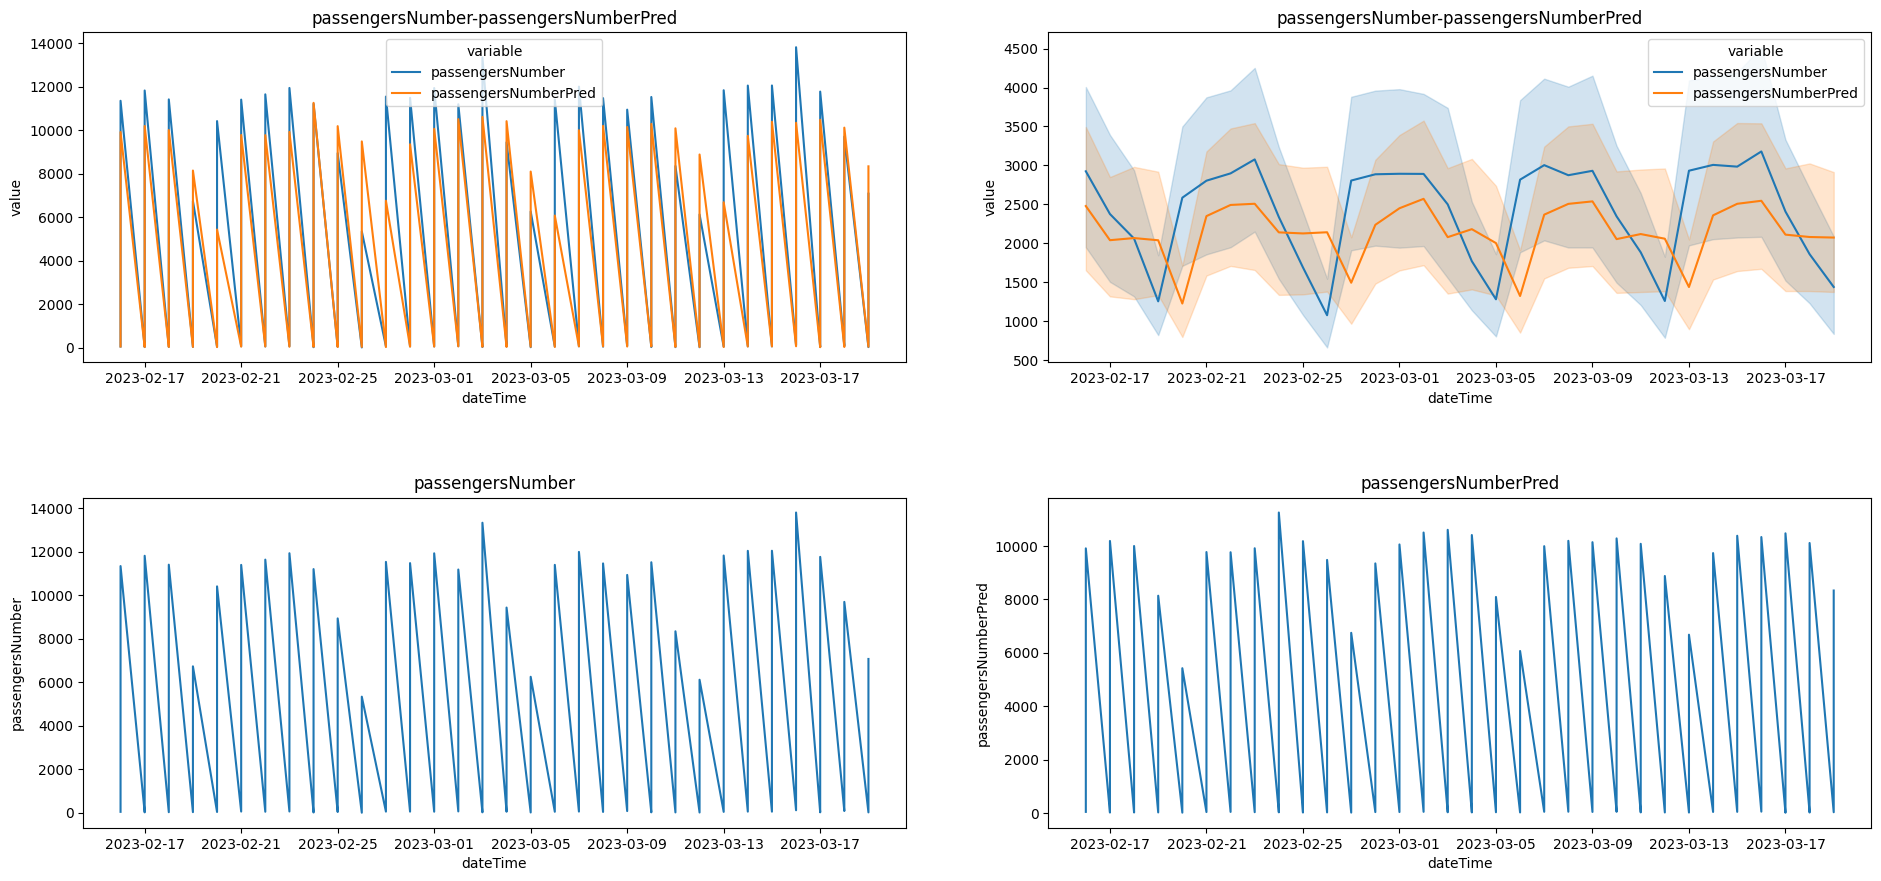

In [17]:
# Evaluation
## Evaluation des performances sur l'ensemble d'entraînement
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = mean_squared_error(y_train, y_train_pred,squared=False)
r2_train = r2_score(y_train, y_train_pred)
## Evaluation des performances sur l'ensemble de test
y_test_pred = model.predict(preprocessor.transform(X_test))
mae_test = mean_absolute_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred,squared=False)
r2_test = r2_score(y_test, y_test_pred)
print("MAE (Entraînement) : {:.2f}".format(mae_train))
print("MAE (Test) : {:.2f}".format(mae_test))
print("RMSE (Entraînement) : {:.2f}".format(rmse_train))
print("RMSE (Test) : {:.2f}".format(rmse_test))
print("R² (Entraînement) : {:.2f}".format(r2_train))
print("R² (Test) : {:.2f}".format(r2_test))

# Visualisation dataframe
X_results = X_test.copy()
X_results["passengersNumber"] = y_test
X_results["passengersNumberPred"] = y_pred
X_results["taux_error"] = X_results.apply(calc_mae, axis=1)
#display(X_results)
X_results_melt = pd.melt(X_results, id_vars =['dateTime'], value_vars =['passengersNumber', 'passengersNumberPred'])
X_results_melt = X_results_melt.sort_values("dateTime")
X_results = X_results.sort_values("dateTime")
#display(X_results_melt.head(10))
# Visualisation graphique
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(20,10))
sns.lineplot(X_results_melt,x="dateTime",y="value",hue="variable",ax=axs[0,0],estimator=None)
axs[0,0].set_title("passengersNumber-passengersNumberPred")
sns.lineplot(X_results_melt,x="dateTime",y="value",hue="variable",ax=axs[0,1])
axs[0,1].set_title("passengersNumber-passengersNumberPred")
sns.lineplot(X_results,x="dateTime",y="passengersNumber",ax=axs[1,0],estimator=None)
axs[1,0].set_title("passengersNumber")
sns.lineplot(X_results,x="dateTime",y="passengersNumberPred",ax=axs[1,1],estimator=None)
axs[1,1].set_title("passengersNumberPred")
fig.tight_layout(pad=5.0)

# Donne la liste résultats mal prédit à un taux acceptable de 0
print("Taux acceptable : 0")
X_results2 = X_results[abs(X_results.taux_error) > 0]
print("Nombre de valeurs mal prédite :",X_results2.shape[0])
print("Années concernées :",X_results2.year.unique())
print("Mois concernés :",X_results2.month.unique(),len(X_results2.month.unique()))
print("Ligne concernées :",X_results2.line.unique(),len(X_results2.line.unique()))
print("Type de ligne concernées :",X_results2.lineType.unique())
print("="*100)
# Donne la liste résultats mal prédit à un taux acceptable de 15
print("Taux acceptable : 15")
X_results2 = X_results[abs(X_results.taux_error) > 15]
print("Nombre de valeurs mal prédite :",X_results2.shape[0])
print("Années concernées :",X_results2.year.unique())
print("Mois concernés :",X_results2.month.unique(),len(X_results2.month.unique()))
print("Ligne concernées :",X_results2.line.unique(),len(X_results2.line.unique()))
print("Type de ligne concernées :",X_results2.lineType.unique())
print("="*100)
# Donne la liste résultats mal prédit à un taux acceptable de 100
print("Taux acceptable : 100")
X_results2 = X_results[abs(X_results.taux_error) > 100]
print("Nombre de valeurs mal prédite :",X_results2.shape[0])
print("Années concernées :",X_results2.year.unique())
print("Mois concernés :",X_results2.month.unique(),len(X_results2.month.unique()))
print("Ligne concernées :",X_results2.line.unique(),len(X_results2.line.unique()))
print("Type de ligne concernées :",X_results2.lineType.unique())
# Donne la liste résultats mal prédit à un taux acceptable de 500
print("="*100)
print("Taux acceptable : 500")
X_results2 = X_results[abs(X_results.taux_error) > 500]
print("Nombre de valeurs mal prédite :",X_results2.shape[0])
print("Années concernées :",X_results2.year.unique())
print("Mois concernés :",X_results2.month.unique(),len(X_results2.month.unique()))
print("Ligne concernées :",X_results2.line.unique(),len(X_results2.line.unique()))
print("Type de ligne concernées :",X_results2.lineType.unique())

In [18]:
break
models.append(
    {
        "model":"RandomForestRegressor",
        "MAE_train":mae_train,
        "MAE_test":mae_test,
        "RMSE_train":rmse_train,
        "RMSE_test":rmse_test,
        "R2_train":r2_train,
        "R2_test":r2_test,
    }
)

SyntaxError: ignored

In [19]:
X_results3 = X_results[abs(X_results.taux_error) > 500]
display(X_results3)

,dateTime,year,month,day,line,lineType,passengersNumber,passengersNumberPred,taux_error
37144,2023-03-05,2023,3,5,27,daily,69,1504.08,-2079.826087


### ARIMA

Recherche du meilleur modèle ARIMA.

In [20]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

model_fit = auto_arima(data_train["passengersNumber"],trace=True,supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=66.48 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=698132.752, Time=0.71 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=687727.936, Time=0.86 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=674560.859, Time=19.42 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=698130.752, Time=0.39 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=674540.606, Time=33.78 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=45.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=47.69 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=674541.683, Time=28.77 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=683471.318, Time=3.04 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=674538.606, Time=13.44 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=674558.858, Time=5.17 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=687725.936, Time=0.44 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=inf, Time=17.64 sec
 ARIMA(1,1,2)(0,0,0)[0]  

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer in

MAE (Test) : 656.13
RMSE (Test) : 1036.77
R² (Test) : 0.86
Taux acceptable : 0
Nombre de valeurs mal prédite : 1052
Années concernées : [2023]
Mois concernés : [2 3] 2
Ligne concernées : [  5  40  38  29  45  43  46  35  42  37  36  32  31   8  28  41  26  33
   6  13  14   9  23  16  21  17  24  25  27  18  19 110 103 104 108 106
 109 101 102] 39
Type de ligne concernées : ['daily' 'night']
Taux acceptable : 15
Nombre de valeurs mal prédite : 980
Années concernées : [2023]
Mois concernés : [2 3] 2
Ligne concernées : [  5  38  29  45  43  46  35  42  37  36  32  31   8  28  41  26  33   6
  13  14   9  23  16  21  17  24  25  27  18  19  40 110 103 104 108 106
 109 101 102] 39
Type de ligne concernées : ['daily' 'night']
Taux acceptable : 100
Nombre de valeurs mal prédite : 406
Années concernées : [2023]
Mois concernés : [2 3] 2
Ligne concernées : [ 38  43  46  35  42  37  31   6  45  40  41 110 103 104 108 106 109 101
 102  27  36  32  33  21  23  24  16  29   9  14  19  18   8  25  2

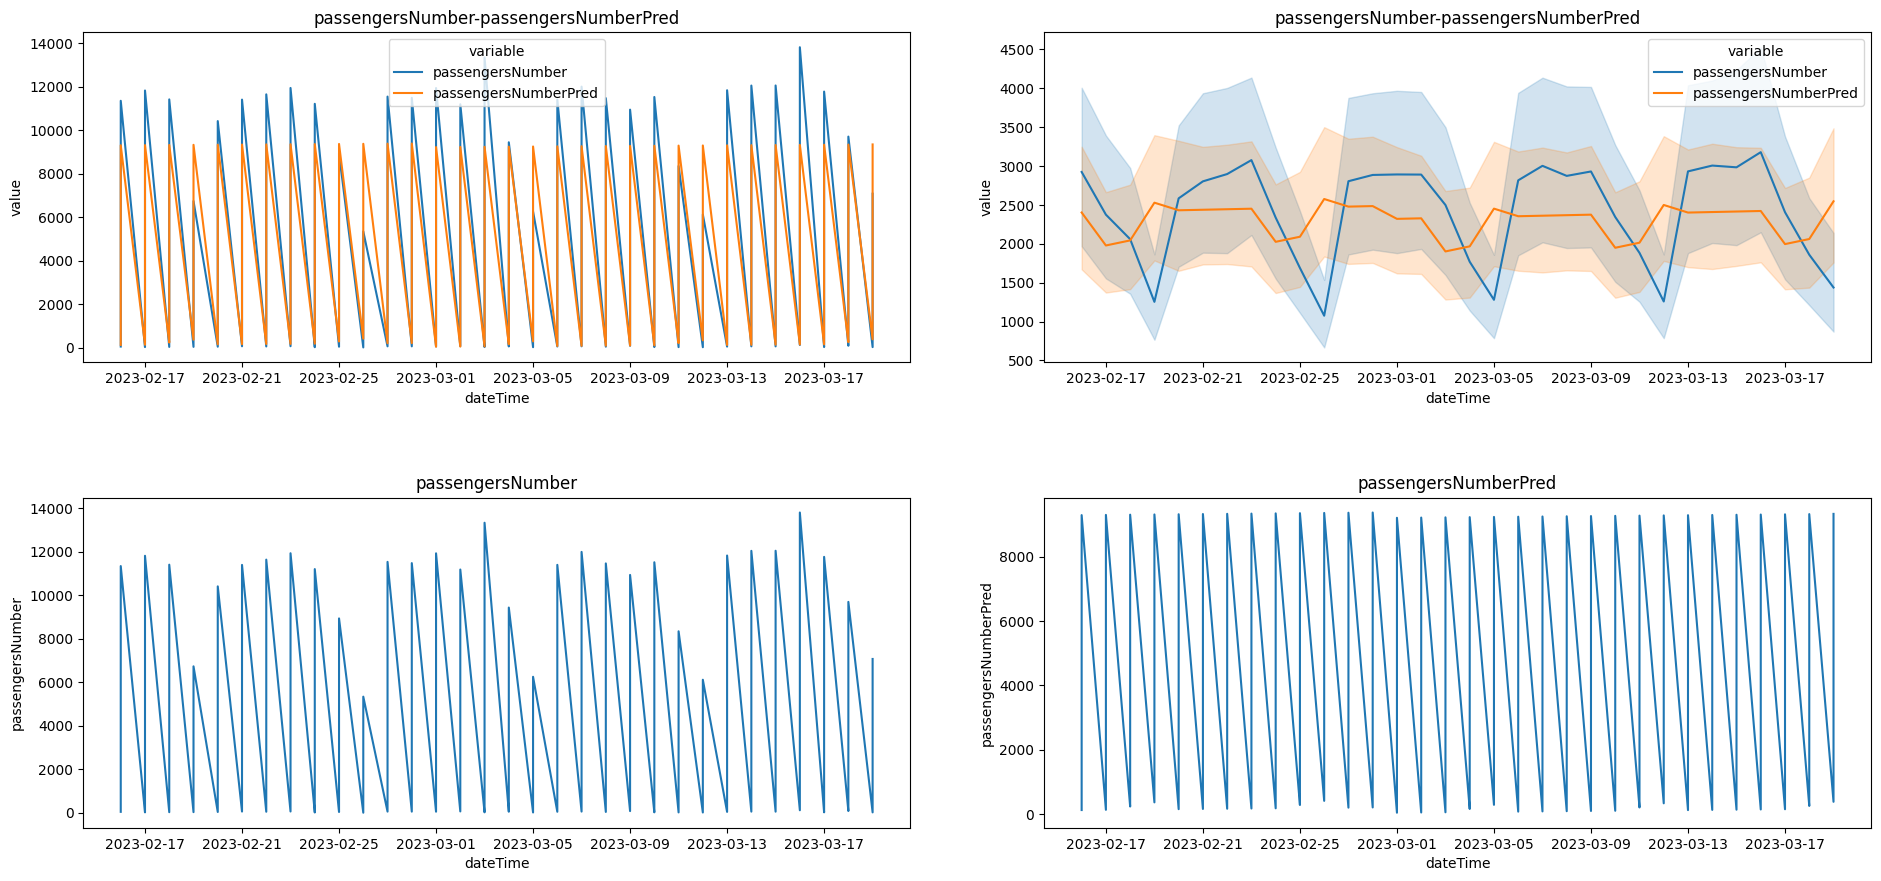

In [21]:
# Entrainement
model = ARIMA(y_train,exog=preprocessor.transform(X_train).toarray(),order=(1,1,1))
model = model.fit()

# Prédiction
start = len(y_train)
end = len(y_train) + len(X_test) - 1
y_pred = model.predict(start=start,end=end,typ='levels',exog=preprocessor.transform(X_test).toarray())

# Evaluation
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred,squared=False)
r2_test = r2_score(y_test, y_pred)
print("MAE (Test) : {:.2f}".format(mae_test))
print("RMSE (Test) : {:.2f}".format(rmse_test))
print("R² (Test) : {:.2f}".format(r2_test))

# Visualisation dataframe
X_results = X_test.copy()
X_results["passengersNumber"] = y_test
X_results["passengersNumberPred"] = y_pred
X_results["taux_error"] = X_results.apply(calc_mae, axis=1)
#display(X_results)
X_results_melt = pd.melt(X_results, id_vars =['dateTime'], value_vars =['passengersNumber', 'passengersNumberPred'])
X_results_melt = X_results_melt.sort_values("dateTime")
X_results = X_results.sort_values("dateTime")
#display(X_results_melt.head(10))
# Visualisation graphique
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(20,10))
sns.lineplot(X_results_melt,x="dateTime",y="value",hue="variable",ax=axs[0,0],estimator=None)
axs[0,0].set_title("passengersNumber-passengersNumberPred")
sns.lineplot(X_results_melt,x="dateTime",y="value",hue="variable",ax=axs[0,1])
axs[0,1].set_title("passengersNumber-passengersNumberPred")
sns.lineplot(X_results,x="dateTime",y="passengersNumber",ax=axs[1,0],estimator=None)
axs[1,0].set_title("passengersNumber")
sns.lineplot(X_results,x="dateTime",y="passengersNumberPred",ax=axs[1,1],estimator=None)
axs[1,1].set_title("passengersNumberPred")
fig.tight_layout(pad=5.0)

# Donne la liste résultats mal prédit à un taux acceptable de 0
print("Taux acceptable : 0")
X_results2 = X_results[abs(X_results.taux_error) > 0]
print("Nombre de valeurs mal prédite :",X_results2.shape[0])
print("Années concernées :",X_results2.year.unique())
print("Mois concernés :",X_results2.month.unique(),len(X_results2.month.unique()))
print("Ligne concernées :",X_results2.line.unique(),len(X_results2.line.unique()))
print("Type de ligne concernées :",X_results2.lineType.unique())
print("="*100)
# Donne la liste résultats mal prédit à un taux acceptable de 15
print("Taux acceptable : 15")
X_results2 = X_results[abs(X_results.taux_error) > 15]
print("Nombre de valeurs mal prédite :",X_results2.shape[0])
print("Années concernées :",X_results2.year.unique())
print("Mois concernés :",X_results2.month.unique(),len(X_results2.month.unique()))
print("Ligne concernées :",X_results2.line.unique(),len(X_results2.line.unique()))
print("Type de ligne concernées :",X_results2.lineType.unique())
print("="*100)
# Donne la liste résultats mal prédit à un taux acceptable de 100
print("Taux acceptable : 100")
X_results2 = X_results[abs(X_results.taux_error) > 100]
print("Nombre de valeurs mal prédite :",X_results2.shape[0])
print("Années concernées :",X_results2.year.unique())
print("Mois concernés :",X_results2.month.unique(),len(X_results2.month.unique()))
print("Ligne concernées :",X_results2.line.unique(),len(X_results2.line.unique()))
print("Type de ligne concernées :",X_results2.lineType.unique())
# Donne la liste résultats mal prédit à un taux acceptable de 500
print("="*100)
print("Taux acceptable : 500")
X_results2 = X_results[abs(X_results.taux_error) > 500]
print("Nombre de valeurs mal prédite :",X_results2.shape[0])
print("Années concernées :",X_results2.year.unique())
print("Mois concernés :",X_results2.month.unique(),len(X_results2.month.unique()))
print("Ligne concernées :",X_results2.line.unique(),len(X_results2.line.unique()))
print("Type de ligne concernées :",X_results2.lineType.unique())

## LSTM

In [22]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

In [ ]:
# Préparation des données
X_train_scaled = preprocessor.transform(X_train).toarray()
X_train_scaled_reshape = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))

# Entrainement
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(1, X_train_scaled.shape[1])))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')
model.fit(X_train_scaled_reshape, y_train, epochs=50, batch_size=16, verbose=1)

Epoch 1/50
2286/2286 [==============================] - 6s 2ms/step - loss: 6147120.5000
Epoch 2/50
2286/2286 [==============================] - 5s 2ms/step - loss: 5455343.0000
Epoch 3/50
2286/2286 [==============================] - 4s 2ms/step - loss: 3360039.0000
Epoch 4/50
2286/2286 [==============================] - 5s 2ms/step - loss: 1917428.0000
Epoch 5/50
2286/2286 [==============================] - 5s 2ms/step - loss: 1567653.8750
Epoch 6/50
2286/2286 [==============================] - 4s 2ms/step - loss: 1439290.0000
Epoch 7/50
2286/2286 [==============================] - 4s 2ms/step - loss: 1408006.3750
Epoch 8/50
2286/2286 [==============================] - 4s 2ms/step - loss: 1391719.5000
Epoch 9/50
2286/2286 [==============================] - 4s 2ms/step - loss: 1406680.3750
Epoch 10/50
2286/2286 [==============================] - 5s 2ms/step - loss: 1389520.8750
Epoch 11/50
2286/2286 [==============================] - 4s 2ms/step - loss: 1385284.8750
Epoch 12/50
2286/22

33/33 [==============================] - 0s 1ms/step
MAE (Test) : 800.75
RMSE (Test) : 1265.12
R² (Test) : 0.79
Taux acceptable : 0
Nombre de valeurs mal prédite : 1052
Années concernées : [2023]
Mois concernés : [2 3] 2
Ligne concernées : [  5  40  38  29  45  43  46  35  42  37  36  32  31   8  28  41  26  33
   6  13  14   9  23  16  21  17  24  25  27  18  19 110 103 104 108 106
 109 101 102] 39
Type de ligne concernées : ['daily' 'night']
Taux acceptable : 15
Nombre de valeurs mal prédite : 924
Années concernées : [2023]
Mois concernés : [2 3] 2
Ligne concernées : [  5  40  38  29  45  43  46  35  42  37  36  32  31   8  28  41  26  33
   6  13  14   9  23  16  21  17  24  25  27  18  19 110 103 104 108 106
 109 101 102] 39
Type de ligne concernées : ['daily' 'night']
Taux acceptable : 100
Nombre de valeurs mal prédite : 59
Années concernées : [2023]
Mois concernés : [2 3] 2
Ligne concernées : [101  35  31  32  36  41  37  27  21  23  24   5  16 106] 14
Type de ligne concernées : 

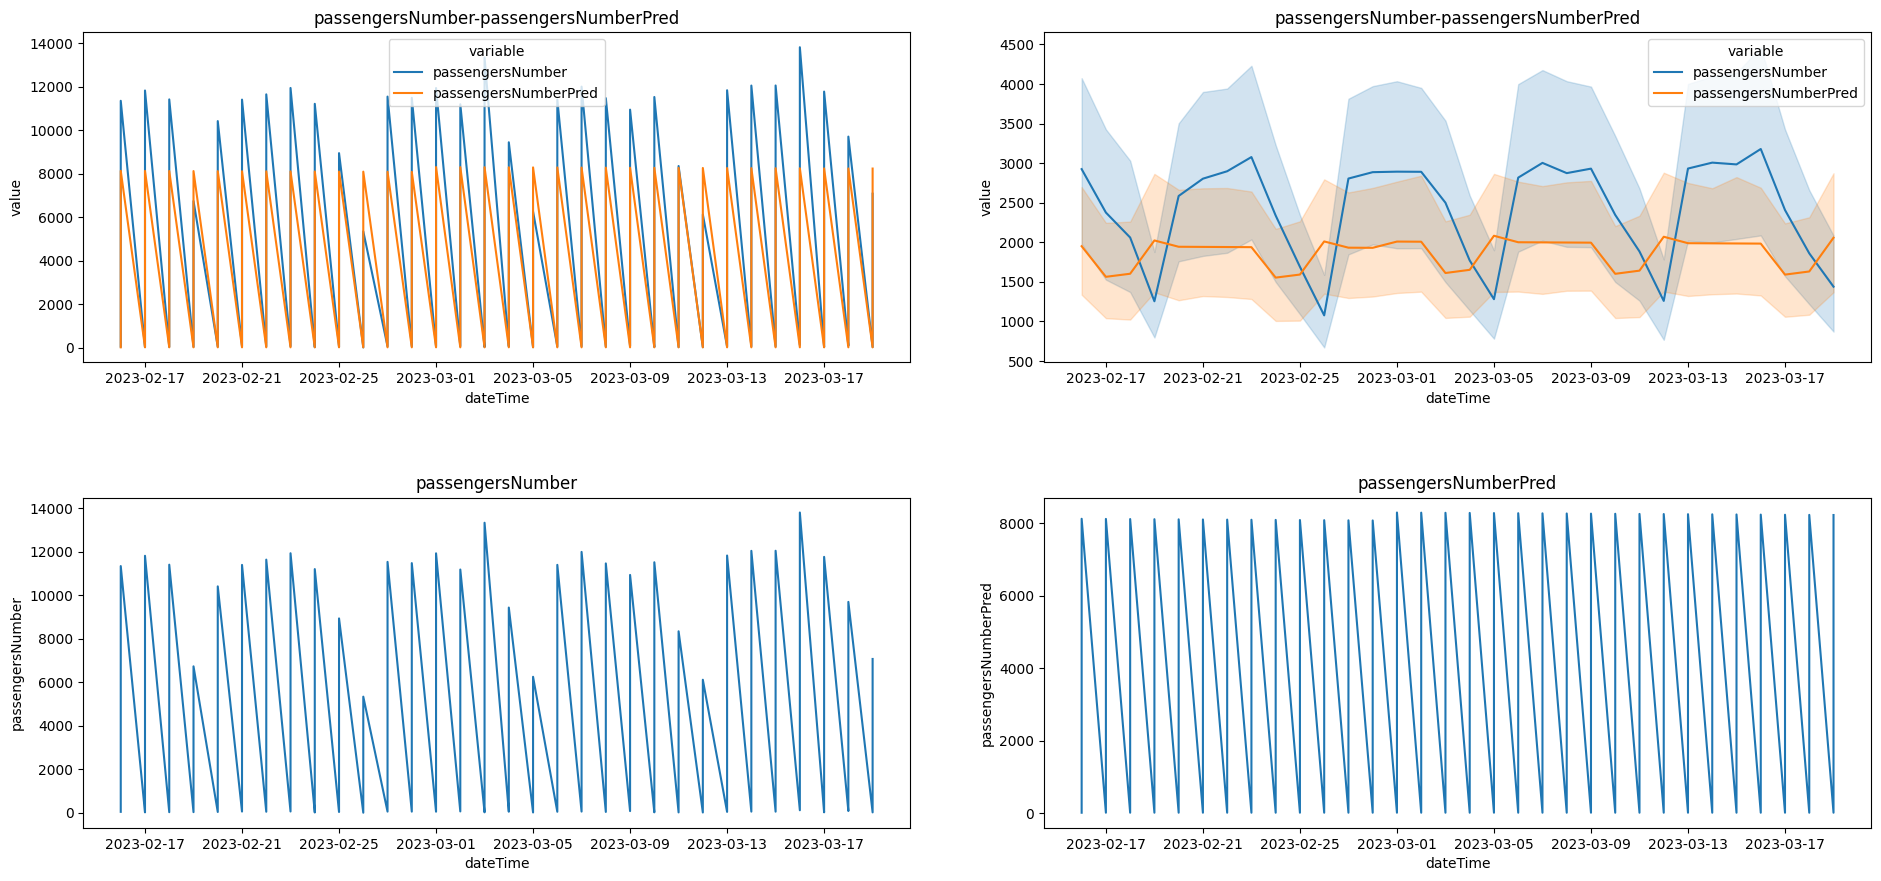

In [ ]:
# Prédiction
X_test_scaled = preprocessor.transform(X_test).toarray()
X_test_scaled_reshape = X_test_scaled.reshape((X_test_scaled.shape[0],1,X_test_scaled.shape[1]))
y_pred = model.predict(X_test_scaled_reshape)

# Evaluation
mae_test = mean_absolute_error(y_test, y_pred)
rmse_test = mean_squared_error(y_test, y_pred,squared=False)
r2_test = r2_score(y_test, y_pred)
print("MAE (Test) : {:.2f}".format(mae_test))
print("RMSE (Test) : {:.2f}".format(rmse_test))
print("R² (Test) : {:.2f}".format(r2_test))

# Visualisation dataframe
X_results = X_test.copy()
X_results["passengersNumber"] = y_test
X_results["passengersNumberPred"] = y_pred
X_results["taux_error"] = X_results.apply(calc_mae, axis=1)
#display(X_results)
X_results_melt = pd.melt(X_results, id_vars =['dateTime'], value_vars =['passengersNumber', 'passengersNumberPred'])
X_results_melt = X_results_melt.sort_values("dateTime")
X_results = X_results.sort_values("dateTime")
#display(X_results_melt.head(10))
# Visualisation graphique
fig, axs = plt.subplots(nrows=2,ncols=2,figsize=(20,10))
sns.lineplot(X_results_melt,x="dateTime",y="value",hue="variable",ax=axs[0,0],estimator=None)
axs[0,0].set_title("passengersNumber-passengersNumberPred")
sns.lineplot(X_results_melt,x="dateTime",y="value",hue="variable",ax=axs[0,1])
axs[0,1].set_title("passengersNumber-passengersNumberPred")
sns.lineplot(X_results,x="dateTime",y="passengersNumber",ax=axs[1,0],estimator=None)
axs[1,0].set_title("passengersNumber")
sns.lineplot(X_results,x="dateTime",y="passengersNumberPred",ax=axs[1,1],estimator=None)
axs[1,1].set_title("passengersNumberPred")
fig.tight_layout(pad=5.0)

# Donne la liste résultats mal prédit à un taux acceptable de 0
print("Taux acceptable : 0")
X_results2 = X_results[abs(X_results.taux_error) > 0]
print("Nombre de valeurs mal prédite :",X_results2.shape[0])
print("Années concernées :",X_results2.year.unique())
print("Mois concernés :",X_results2.month.unique(),len(X_results2.month.unique()))
print("Ligne concernées :",X_results2.line.unique(),len(X_results2.line.unique()))
print("Type de ligne concernées :",X_results2.lineType.unique())
print("="*100)
# Donne la liste résultats mal prédit à un taux acceptable de 15
print("Taux acceptable : 15")
X_results2 = X_results[abs(X_results.taux_error) > 15]
print("Nombre de valeurs mal prédite :",X_results2.shape[0])
print("Années concernées :",X_results2.year.unique())
print("Mois concernés :",X_results2.month.unique(),len(X_results2.month.unique()))
print("Ligne concernées :",X_results2.line.unique(),len(X_results2.line.unique()))
print("Type de ligne concernées :",X_results2.lineType.unique())
print("="*100)
# Donne la liste résultats mal prédit à un taux acceptable de 100
print("Taux acceptable : 100")
X_results2 = X_results[abs(X_results.taux_error) > 100]
print("Nombre de valeurs mal prédite :",X_results2.shape[0])
print("Années concernées :",X_results2.year.unique())
print("Mois concernés :",X_results2.month.unique(),len(X_results2.month.unique()))
print("Ligne concernées :",X_results2.line.unique(),len(X_results2.line.unique()))
print("Type de ligne concernées :",X_results2.lineType.unique())
# Donne la liste résultats mal prédit à un taux acceptable de 500
print("="*100)
print("Taux acceptable : 500")
X_results2 = X_results[abs(X_results.taux_error) > 500]
print("Nombre de valeurs mal prédite :",X_results2.shape[0])
print("Années concernées :",X_results2.year.unique())
print("Mois concernés :",X_results2.month.unique(),len(X_results2.month.unique()))
print("Ligne concernées :",X_results2.line.unique(),len(X_results2.line.unique()))
print("Type de ligne concernées :",X_results2.lineType.unique())